https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
# prepare data for lstm
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df =  DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# load dataset
dataset = read_csv('SeoulBikeData.csv', encoding= 'unicode_escape', header=0, index_col=0)

# bikes = dataset['Rented Bike Count']
# dataset = dataset.drop(columns=['Rented Bike Count'])
# dataset.insert(loc=12, column='Rented Bike Count', value=bikes)


values = dataset.values

In [4]:
# encode the categorical variables into integers
label_encoder = LabelEncoder()
values[:,12] = label_encoder.fit_transform(values[:,12])
values[:,10] = label_encoder.fit_transform(values[:,10])
values[:,11] = label_encoder.fit_transform(values[:,11])

In [5]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [6]:
# # frame as supervised learning
# reframed = series_to_supervised(scaled, 23, 1)
# # drop columns we don't want to predict
# #reframed.drop(reframed.columns[[number,of,columns]], axis=1, inplace=True)
# print(reframed.head())

In [7]:
# frame as supervised learning
hours_to_consider = 23
reframed = series_to_supervised(scaled, hours_to_consider, 1)
#reframed.reset_index(drop=True, inplace=True)
# drop columns we don't want to predict
# columns_to_keep = list()
# for i in range(15,reframed.shape[1]+1,13):
#     columns_to_keep.append(i)
# print(columns_to_keep)
# x = 11
# n_cols = [i for i in range (13, 216+1)]
# for i in columns_to_keep:
#     n_cols.remove(i)
# n_cols = [x - 1 for x in n_cols]
# reframed.drop(reframed.columns[[n_cols]], axis=1, inplace=True)
# print(reframed.columns)
# print(reframed.head())

In [8]:
# split into train and test sets
values = reframed.values
train_ratio = 0.9
test_ratio = 1 - train_ratio
n_train_hours = int(365 * 24 * 0.9)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

In [9]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7884, 1, 311) (7884,) (853, 1, 311) (853,)


In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.optimizers import SGD

from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.metrics import MeanAbsoluteError
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def adj_r2(r2):
  n = train_X.shape[0]
  p = train_X.shape[2]
  return (1-(1-r2)*(n-1)/(n-p-1))

Epoch 1/5
112/112 - 3s - loss: 0.2790 - accuracy: 0.0067 - mean_squared_error: 0.1352 - root_mean_squared_error: 0.3677 - mean_absolute_error: 0.2790 - val_loss: 0.1610 - val_accuracy: 0.1479 - val_mean_squared_error: 0.0383 - val_root_mean_squared_error: 0.1957 - val_mean_absolute_error: 0.1610
Epoch 2/5
112/112 - 0s - loss: 0.1602 - accuracy: 0.0067 - mean_squared_error: 0.0428 - root_mean_squared_error: 0.2069 - mean_absolute_error: 0.1602 - val_loss: 0.1470 - val_accuracy: 0.1479 - val_mean_squared_error: 0.0323 - val_root_mean_squared_error: 0.1798 - val_mean_absolute_error: 0.1470
Epoch 3/5
112/112 - 0s - loss: 0.1243 - accuracy: 0.0073 - mean_squared_error: 0.0258 - root_mean_squared_error: 0.1606 - mean_absolute_error: 0.1243 - val_loss: 0.1402 - val_accuracy: 0.1479 - val_mean_squared_error: 0.0294 - val_root_mean_squared_error: 0.1716 - val_mean_absolute_error: 0.1402
Epoch 4/5
112/112 - 0s - loss: 0.1074 - accuracy: 0.0073 - mean_squared_error: 0.0197 - root_mean_squared_err

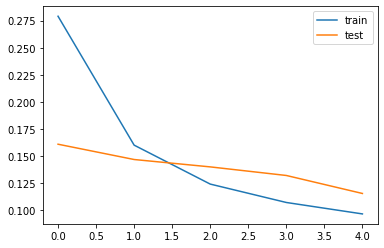

(853, 13)
Test RMSE: 222743.945
Test RMSE2: 471.958
Test MAE: 386.564
Test R2: 0.087
Test ADJ R2: 0.050


In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(BatchNormalization(axis=-1, 
                            momentum=0.99,
                            epsilon=0.001,
                            center=True,
                            scale=True,
                            beta_initializer='zeros',
                            gamma_initializer='ones',
                            moving_mean_initializer='zeros',
                            moving_variance_initializer='ones',
                            beta_regularizer=None,
                            gamma_regularizer=None,
                            beta_constraint=None,
                            gamma_constraint=None
                            ))
model.add(Dense(1))

model.compile(loss='mae',
              optimizer=SGD(lr=0.01),
              metrics=["accuracy", 
                       MeanSquaredError(), 
                       RootMeanSquaredError(),
                       MeanAbsoluteError()])

# fit network
history = model.fit(train_X, 
                    train_y,
                    validation_split=0.15,
                    epochs=50,
                    batch_size=60,
                    verbose=2,
                    shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
oi = np.random.randint(1,101,size=(853,12))
inv_yhat = concatenate((yhat, oi), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, oi), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate R2
r2 = r2_score(inv_y, inv_yhat)
adj_r2 = adj_r2(r2)
print('Test R2: %.3f' % r2)
print('Test ADJ R2: %.3f' % adj_r2)

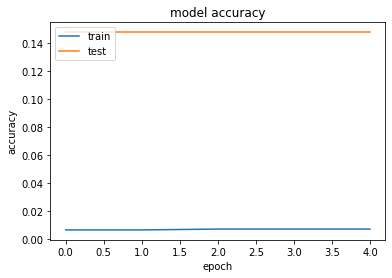

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()